# Note
Before running this notebook, expand the tarball `{repo_root}/tests/data/SEQUOIA_data/Mn3Si2Te6-mcvine-res-sim.tgz` to directory `{repo_root}/tests/data/SEQUOIA_data/Mn3Si2Te6/`. It will create a subdir `mcvine-res-sim` there.

# Compare Violini with mcvine sims

In [1]:
# some goodies
# %matplotlib notebook
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np, os, glob, sys
import histogram.hdf as hh, histogram as H

import mcvine.cli
from mcvine.workflow.DGS import ARCS
from mcvine.workflow import singlextal as sx
from mcvine.workflow.sample import loadSampleYml
from mcvine.workflow.singlextal import io as sxio, coords_transform, dynrange

In [2]:
# sys.path.insert(0, '/SNS/users/linjiao/dv/mcvine/dgsres/')
sys.path.insert(0, '/home/linjiao/dv/neutron/mcvine/dgsres/')

In [3]:
import dgsres

In [4]:
from dgsres.singlextal import use_covmat, use_res_comps, plot as resplot, workflow, violini, simdata
from dgsres import instruments

In [5]:
from imp import reload

In [6]:
reload(resplot)
reload(use_covmat)
reload(instruments)
reload(simdata)
reload(violini)

<module 'dgsres.singlextal.violini' from '/home/linjiao/dv/neutron/mcvine/dgsres/dgsres/singlextal/violini.py'>

In [7]:
srcdir = os.path.abspath('.')
srcdir

'/home/linjiao/dv/neutron/mcvine/dgsres/notebooks/singlextal/Mn3Si2Te6-SEQ'

In [8]:
# workdir = '/SNS/SEQ/IPTS-21411/shared/resolution/02012023'
workdir = os.path.abspath("work")
!mkdir -p {workdir}
%cd {workdir}

/home/linjiao/dv/neutron/mcvine/dgsres/notebooks/singlextal/Mn3Si2Te6-SEQ/work


In [9]:
import shutil

In [10]:
files = 'sample.yaml convolution_config.py resolution_workflow_config.py '.split()
for f in files:
    shutil.copyfile(os.path.join(srcdir, f), os.path.join(workdir, f))

# load configuration

In [11]:
import imp
config = imp.load_source('config', 'convolution_config.py')

In [12]:
sl = config.rwc.slices[0]

In [13]:
sl

rwc.Slice_00L

# Comparison plot of cloud and ellipsoid

## Load mcvine model

In [14]:
class McvineResData(resplot.McvineResolutionData):
    def path(self, q, E):
        return os.path.join(self.parent_dir, config.rwc.simdir(q, E, sl))

In [15]:
#mcvinesim = '/SNS/SEQ/IPTS-21411/shared/resolution/mcvinesim/'
mcvinesim = os.path.join(srcdir, '../../../tests/data/SEQUOIA_data/Mn3Si2Te6/mcvine-res-sim')

In [16]:
mrd = McvineResData(mcvinesim, dirname_template=None)

In [17]:
#ls {mcvinesim}

In [18]:
ls {mcvinesim}/sim-00L-q_3.100,E_19.000/

dEs.npy    dxs.npy                 mc_params.yml      probs.npy  run.py
dhkls.npy  instrument7g15zupr.pkl  pixel4k5kv1ys.pkl  res.h5     sample/


In [19]:
sl

rwc.Slice_00L

In [20]:
q1, E1 = 3.1, 19.
hkl1 = sl.hkl0+sl.hkl_projection*q1

mcvine_pc1 = mrd.loadPointCloud(q1, E1)
mcvine_cm1 = mrd.computeCovMat(q1, E1, dhkl_ranges=[(-0.2,0.2)]*3)
print(mcvine_cm1)

[[ 1.91513300e-03 -2.54398642e-04  1.63341994e-03  3.58253004e-02]
 [-2.54398642e-04  7.90565327e-04  1.53782776e-04  3.74214632e-03]
 [ 1.63341994e-03  1.53782776e-04  4.13309354e-03  5.24305194e-02]
 [ 3.58253004e-02  3.74214632e-03  5.24305194e-02  8.90417391e-01]]


## Violini model

In [21]:
violini_model = workflow.create_violini_model(config.rwc, 0.01)
violini_cm1 = violini_model.computeCovMat(hkl1, E1)
print(violini_cm1)

violini_pc1 = violini_model.computePointCloud(hkl1, E1)

/home/linjiao/miniconda3/envs/mcvine/lib/python3.8/site-packages/mcvine/workflow/singlextal/solve_psi.py:56: UserWarning: Traceback (most recent call last):
  File "/home/linjiao/miniconda3/envs/mcvine/lib/python3.8/site-packages/mcvine/workflow/singlextal/solve_psi.py", line 53, in solve
    results.append(solver(res, min, max))
  File "/home/linjiao/miniconda3/envs/mcvine/lib/python3.8/site-packages/scipy/optimize/_zeros_py.py", line 784, in brentq
    r = _zeros._brentq(f, a, b, xtol, rtol, maxiter, args, full_output, disp)
ValueError: f(a) and f(b) must have different signs

  warnings.warn(tb.format_exc())


[[ 1.44901166e-03 -8.06890356e-04 -6.85152477e-04  8.72058749e-03]
 [-8.06890356e-04  1.58682496e-03 -7.20936536e-05  9.52557961e-04]
 [-6.85152477e-04 -7.20936536e-05  4.24161211e-03  1.72808548e-02]
 [ 8.72058749e-03  9.52557961e-04  1.72808548e-02  2.34119649e-01]]


# Compare mcvine sim with violini: (q, E)

/tmp/ipykernel_1018458/727963085.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(hg1, Eg1, I1.T)
/tmp/ipykernel_1018458/727963085.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(hg1, Eg1, I1.T)
/tmp/ipykernel_1018458/727963085.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass sha

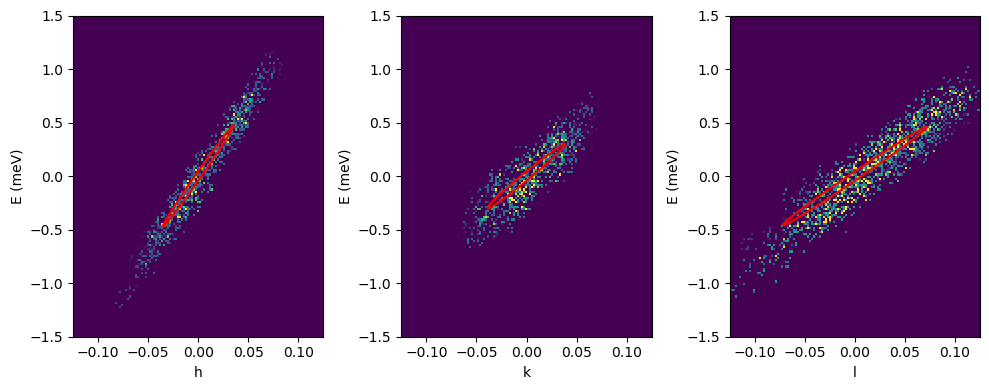

In [22]:
plt.figure(figsize=(10,4))
directions = [
    ('h', [1,0,0]),
    ('k', [0,1,0]),
    ('l', [0,0,1]), 
]
for i, direction in enumerate(directions):
    name, vector = direction
    axis1 = name, -0.5, 0.5, 0.002
    axis2 = 'E', -5, 5., 0.02
    otheraxes = [ (n, -0.015, 0.015) for n,v in directions if n !=name]
    
    plt.subplot(1,3,i+1)
    hg1, Eg1, I1 = mcvine_pc1.getThinSlice(axis1, axis2, *otheraxes)
    plt.pcolormesh(hg1, Eg1, I1.T)
    plt.ylim(-1.5,1.5)
    plt.xlim(-.125, .125)
    plt.xlabel(name)
    plt.ylabel('E (meV)')
    plt.clim(0, np.max(I1)/2)
    resplot.plot_qE_ellipse(violini_cm1, vector, 'r') #, label='Violini')
    # plt.legend()
plt.tight_layout()

# Compare mcvine sim with violini: (q1, q2)

/tmp/ipykernel_1018458/1841452879.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(hg1, Eg1, I1.T)
/tmp/ipykernel_1018458/1841452879.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(hg1, Eg1, I1.T)
/tmp/ipykernel_1018458/1841452879.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass 

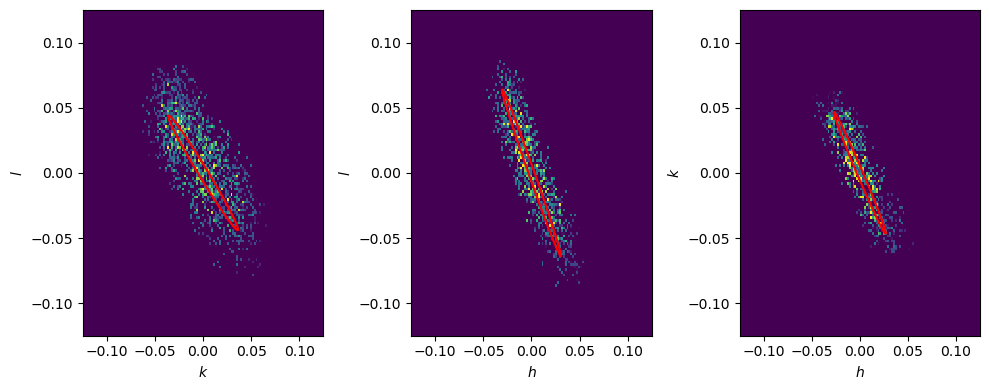

In [23]:
plt.figure(figsize=(10,4))
directions = [
    ('h', [1,0,0]),
    ('k', [0,1,0]),
    ('l', [0,0,1]), 
]
for i, direction in enumerate(directions):
    name, vector = direction
    qs = [ q for n, q in directions if n != name ]
    axes = [ (n, -0.5, 0.5, 0.002) for n,q in directions if n!=name ]
    oaxis1 = name, -0.015, 0.015
    oaxis2 = 'E', -0.2, 0.2
    otheraxes = [ oaxis1, oaxis2 ]
    
    plt.subplot(1,3,i+1)
    hg1, Eg1, I1 = mcvine_pc1.getThinSlice(axes[0], axes[1], *otheraxes)
    plt.pcolormesh(hg1, Eg1, I1.T)
    plt.ylim(-.125, .125)
    plt.xlim(-.125, .125)
    plt.xlabel(f'${axes[0][0]}$')
    plt.ylabel(f'${axes[1][0]}$')
    plt.clim(0, np.max(I1)/2)
    resplot.plot_qq_ellipse(violini_cm1, qs[0], qs[1], 'r')
    # plt.legend()
plt.tight_layout()

# Compare Violini point cloud with Violini ellipse, MCViNE sim point cloud with ellipse from cov matrix calc from MCViNE sim point cloud

/tmp/ipykernel_1018458/6102574.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(hg1, Eg1, I1.T)
/tmp/ipykernel_1018458/6102574.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(hg1, Eg1, I1.T)
/tmp/ipykernel_1018458/6102574.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='

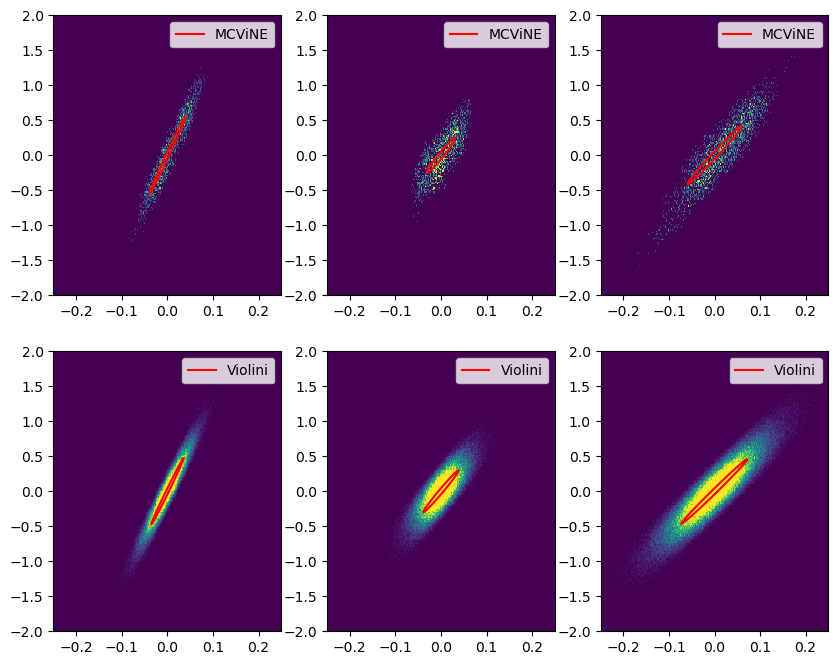

In [24]:
plt.figure(figsize=(10,8))
directions = [
    ('h', [1,0,0]),
    ('k', [0,1,0]),
    ('l', [0,0,1]), 
]
for i, direction in enumerate(directions):
    name, vector = direction
    axis1 = name, -0.5, 0.5, 0.002
    axis2 = 'E', -5, 5., 0.02
    otheraxes = [ (n, -0.02, 0.02) for n,v in directions if n !=name]
    
    plt.subplot(2,3,i+4)
    hg1, Eg1, I1 = violini_pc1.getThinSlice(axis1, axis2, *otheraxes)
    plt.pcolormesh(hg1, Eg1, I1.T)
    plt.clim(0, np.max(I1)/2)
    plt.ylim(-2,2)
    plt.xlim(-.25, .25)
    resplot.plot_qE_ellipse(violini_cm1, vector, 'r', label='Violini')
    plt.legend()
    
    plt.subplot(2,3,i+1)
    hg1, Eg1, I1 = mcvine_pc1.getThinSlice(axis1, axis2, *otheraxes)
    plt.pcolormesh(hg1, Eg1, I1.T)
    plt.ylim(-2,2)
    plt.xlim(-.25, .25)
    plt.clim(0, np.max(I1)/2)
    resplot.plot_qE_ellipse(mcvine_cm1, vector, 'r', label='MCViNE')
    plt.legend()